In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from scipy import stats
import numpy as np

In [2]:
arff_data = arff.loadarff('../data/TimeBasedFeatures-Dataset-15s.arff')
df = pd.DataFrame(arff_data[0])
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,b'CHAT'
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,b'CHAT'
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,b'CHAT'
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,b'CHAT'
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,b'CHAT'


In [3]:
one_hot_labels = pd.get_dummies(df['class1'])
one_hot_labels.head()

,b'BROWSING',b'CHAT',b'FT',b'MAIL',b'P2P',b'STREAMING',b'VOIP',b'VPN-BROWSING',b'VPN-CHAT',b'VPN-FT',b'VPN-MAIL',b'VPN-P2P',b'VPN-STREAMING',b'VPN-VOIP'
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
mean = np.mean(df.iloc[:, :-1].values, axis=0, keepdims=True)
std = np.std(df.iloc[:, :-1].values, axis=0, keepdims=True)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = (df.iloc[:, :-1].values - mean)/std
y = one_hot_labels.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), stddev=1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
class Intermediate(layers.Layer):

    def __init__(self, latent_dim=8, name="Intermediate", **kwargs):
        super(Intermediate, self).__init__(name=name, **kwargs)
        self.mean = Dense(latent_dim)
        self.log_var = Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean = self.mean(inputs)
        z_log_var = self.log_var(inputs)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z
    
    
    def get_config(self):
        config = super().get_config().copy()
        return config

In [10]:
latent_dim = 8

In [11]:
vae_encoder = load_model('../models/vae_encoder.h5', custom_objects={"Intermediate": Intermediate}, compile=False, )

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [12]:
vae_encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 23)]              0         
_________________________________________________________________
latent_model (Sequential)    (None, 64)                47296     
_________________________________________________________________
Intermediate (Intermediate)  ((None, 8), (None, 8), (N 1040      
Total params: 48,336
Trainable params: 48,336
Non-trainable params: 0
_________________________________________________________________


In [47]:
vae_encoder.trainable = False

In [48]:
inp= Input(shape= (X_train.shape[-1], ), name='Input')
z_mean, z_log_var, z = vae_encoder(inp)

In [49]:
classifier = Sequential([
                      Dense(64, input_shape=(latent_dim, ), activation='relu'),
                      Dense(32, activation='relu'),

                      Dense(y_train.shape[-1], activation='softmax')
], name='Classifier')

In [50]:
classifier.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 14)                462       
Total params: 3,118
Trainable params: 3,118
Non-trainable params: 0
_________________________________________________________________


In [51]:
classifier = load_model('../models/classifier.h5', compile=False, )

In [52]:
full_model = Model(inputs = inp, outputs = classifier(z), name = 'full_model')

In [53]:
full_model.summary()

Model: "full_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 23)]              0         
_________________________________________________________________
Encoder (Functional)         [(None, 8), (None, 8), (N 48336     
_________________________________________________________________
Classifier (Sequential)      (None, 14)                3118      
Total params: 51,454
Trainable params: 3,118
Non-trainable params: 48,336
_________________________________________________________________


In [70]:
full_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [76]:
full_model.fit(X_train, y_train, batch_size= 10000, epochs= 100)

Epoch 1/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3031 - accuracy: 0.8805
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3026 - accuracy: 0.8835
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3028 - accuracy: 0.8818
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.3031 - accuracy: 0.8797
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3030 - accuracy: 0.8819
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.3030 - accuracy: 0.8833
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3031 - accuracy: 0.8824
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3027 - accuracy: 0.8795
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 0.3028 - accuracy: 0.8830
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3026 - accuracy: 0.8828
Epoch 11/100
2/2 [===========

2/2 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.8831
Epoch 85/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.8833
Epoch 86/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.8818
Epoch 87/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3015 - accuracy: 0.8832
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 0.3014 - accuracy: 0.8833
Epoch 89/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8803
Epoch 90/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.8825
Epoch 91/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3021 - accuracy: 0.8825
Epoch 92/100
2/2 [==============================] - 0s 6ms/step - loss: 0.3018 - accuracy: 0.8841
Epoch 93/100
2/2 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8827
Epoch 94/100
2/2 [===============

In [22]:
vae_encoder.trainable = True
full_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
full_model.fit(X_train, y_train, batch_size= 10000, epochs= 10)

Epoch 1/10
2/2 [==============================] - 0s 5ms/step - loss: 1.2862 - accuracy: 0.7406
Epoch 2/10
2/2 [==============================] - 0s 6ms/step - loss: 2.0250 - accuracy: 0.6558
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5482 - accuracy: 0.6391
Epoch 4/10
2/2 [==============================] - 0s 5ms/step - loss: 1.4293 - accuracy: 0.6356
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 1.2235 - accuracy: 0.6888
Epoch 6/10
2/2 [==============================] - 0s 5ms/step - loss: 1.0482 - accuracy: 0.7033
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 0.9351 - accuracy: 0.7201
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 0.8422 - accuracy: 0.7425
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 0.7558 - accuracy: 0.7595
Epoch 10/10
2/2 [==============================] - 0s 4ms/step - loss: 0.7130 - accuracy: 0.7531


In [77]:
y_prediction  = np.argmax(full_model(X_test), axis=1)

In [78]:
y_test2 = np.argmax( y_test, axis=1)

In [79]:
np.sum(y_prediction==y_test2)/len(y_prediction)

0.744136460554371

In [85]:
classifier.save('../models/classifier.h5')
vae_encoder.save('../models/vae_encoder.h5')

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [87]:
M = confusion_matrix( y_test2, y_prediction, normalize='true')

In [88]:
class_names = one_hot_labels.columns

Text(69.0, 0.5, 'True label')

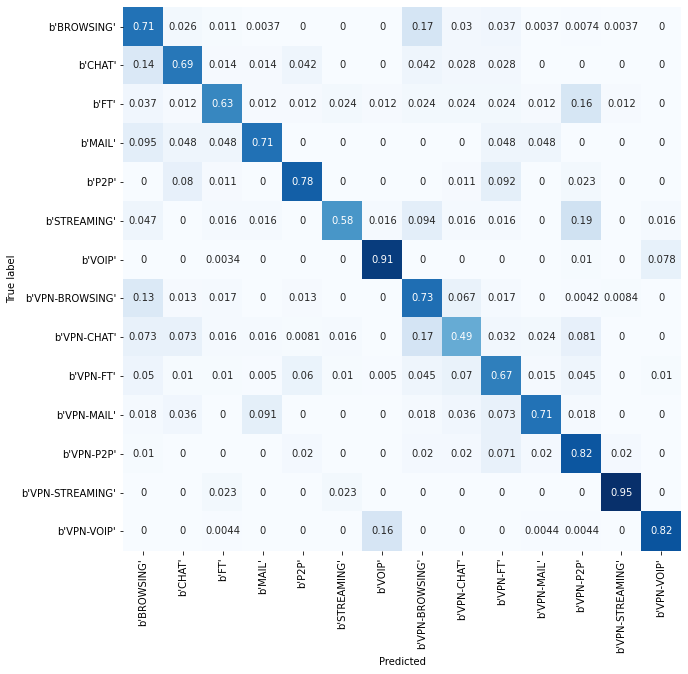

In [89]:
plt.figure(figsize=(10, 10))
sns.heatmap(M, xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, )
plt.xlabel('Predicted')
plt.ylabel('True label')